In [ ]:
# %% [markdown]
"""
# Corn DON Concentration Prediction using Hyperspectral Data

This notebook demonstrates a production-ready machine learning pipeline for predicting DON concentration in corn samples using hyperspectral imaging data. The pipeline includes:

- **Data Loading & Exploration:** Inspect the dataset, check missing values, and visualize key features.
- **Preprocessing:** Impute missing values, standardize data, and optionally reduce dimensionality with PCA.
- **Model Training:** Build and train a simple neural network using Keras with early stopping.
- **Evaluation:** Compute regression metrics, create actual vs. predicted scatter plots, and perform residual analysis.



"""

# %% [markdown]
# ## 1. Import Libraries and Configure Logging

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# %% [markdown]
# ## 2. Data Loading and Exploration
#
# Load the dataset, check for missing values, and generate summary statistics.
# %%
# Update this path to point to your CSV file
data_path = "MLE-Assignment.csv"
try:
    data = pd.read_csv(data_path)
    logger.info("Dataset loaded successfully.")
except Exception as e:
    logger.error(f"Error loading dataset: {e}")
    raise

# Display the first few rows of the dataset
data.head()

# %%
# Check for missing values and print summary statistics
print("Missing values per column:\n", data.isnull().sum())
print("\nSummary statistics:")
print(data.describe())

Missing values per column:
 hsi_id           0
0                0
1                0
2                0
3                0
                ..
444              1
445              1
446              1
447              1
vomitoxin_ppb    1
Length: 450, dtype: int64

Summary statistics:
                0           1           2           3           4           5  \
count  246.000000  246.000000  246.000000  246.000000  246.000000  246.000000   
mean     0.443116    0.441790    0.434596    0.427940    0.420062    0.413265   
std      0.044671    0.046149    0.045351    0.046080    0.044551    0.044792   
min      0.314487    0.295321    0.284064    0.282054    0.307285    0.286860   
25%      0.408430    0.404477    0.397135    0.391602    0.385919    0.377350   
50%      0.445376    0.441591    0.434849    0.426841    0.413805    0.409732   
75%      0.479611    0.481218    0.471014    0.465417    0.459185    0.451436   
max      0.556287    0.530168    0.528774    0.518582    0.511909   

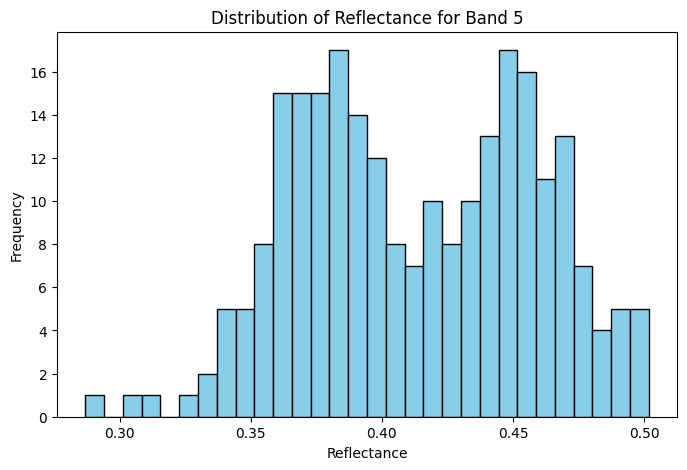

In [ ]:
# %%
# Example visualization for a spectral band.
# Here, we use band "5" (adjust the band number as needed).
band = "5"  # Change this to another band if desired

if band in data.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(data[band].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Reflectance for Band {band}")
    plt.xlabel("Reflectance")
    plt.ylabel("Frequency")
    plt.show()
else:
    print(f"Column '{band}' not found in the dataset.")



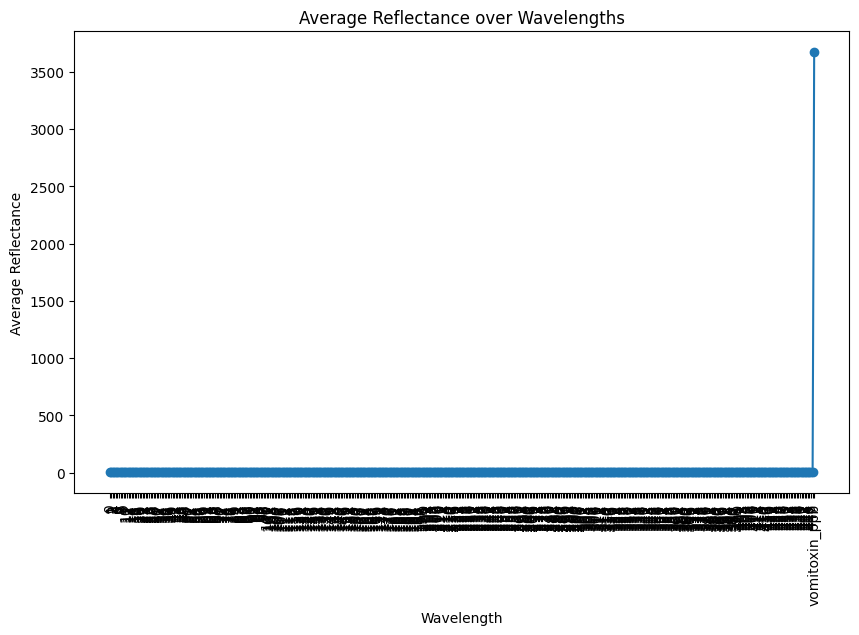

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 40719404.0000 - mae: 2023.0896 - val_loss: 17190446.0000 - val_mae: 2325.1416
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 48595168.0000 - mae: 1845.7810 - val_loss: 17183550.0000 - val_mae: 2323.9417
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 31206372.0000 - mae: 1877.0187 - val_loss: 17176390.0000 - val_mae: 2322.7085
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 57913472.0000 - mae: 2390.6987 - val_loss: 17168620.0000 - val_mae: 2321.4102
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 72736992.0000 - mae: 2273.8218 - val_loss: 17160534.0000 - val_mae: 2320.0522
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 115611056.0000 - mae: 2976.8247 - val_loss: 17151604.0000 - val_mae: 2318.5317
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 37692972.0000 - mae: 2232.2080 - val_loss: 17142252.0000 - val_mae: 2316.9036
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/st

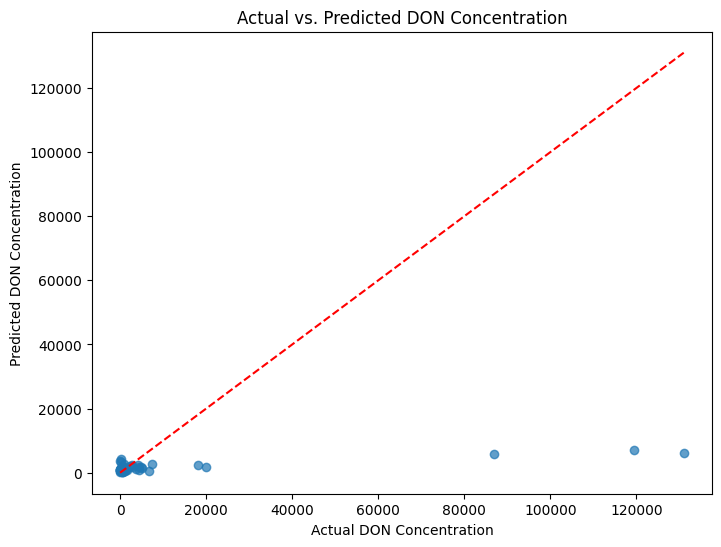

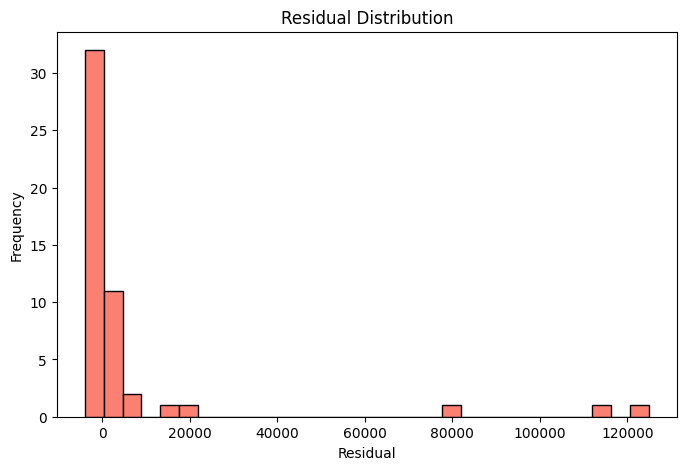

In [ ]:
# %% [markdown]
# ## 3. Data Preprocessing
#
# This section includes missing value imputation, feature standardization, and optional dimensionality reduction via PCA.

"""# %%
# Impute missing values with the mean value for each column
data.fillna(data.mean(), inplace=True)
logger.info("Missing values imputed using column means.")
"""



# %%
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
logger.info("Missing values in numeric columns imputed using column means.")

# %%
# Define target and feature columns
target_col = "vomitoxin_ppb"
if target_col not in data.columns:
    logger.error("Target column not found in dataset!")
    raise ValueError("Target column not found in dataset!")






# %%
# Drop the non-numeric 'hsi_id' column from the DataFrame.
if 'hsi_id' in data.columns:
    features = data.drop(columns=['hsi_id'])
else:
    features = data.copy()

target = data[target_col]



# Standardize features using only numeric columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
logger.info("Features standardized.")



# %%
# Apply PCA to reduce dimensionality while retaining 95% variance
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)
logger.info(f"PCA applied. Original features: {scaled_features.shape[1]}, Reduced features: {pca_features.shape[1]}")

# %%
# Visualize average reflectance across wavelengths (using original features)
avg_reflectance = features.mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_reflectance.index, avg_reflectance.values, marker='o')
plt.title("Average Reflectance over Wavelengths")
plt.xlabel("Wavelength")
plt.ylabel("Average Reflectance")
plt.xticks(rotation=90)
plt.show()

# %% [markdown]
# ## 4. Model Training
#
# Split the data into training and testing sets and build a simple neural network using Keras.

# %%
# Use the PCA-transformed features for modeling
X_train, X_test, y_train, y_test = train_test_split(pca_features, target.values, test_size=0.2, random_state=42)
logger.info(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# %%
# Define a function to build the neural network model
def build_model(input_dim: int) -> Sequential:
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build and summarize the model
model = build_model(X_train.shape[1])
model.summary()

# %%
# Train the model using early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# %% [markdown]
# ## 5. Model Evaluation
#
# Compute evaluation metrics and visualize model performance.

# %%
# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
logger.info(f"Evaluation Metrics - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# %%
# Scatter plot: Actual vs. Predicted DON Concentration
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

# %%
# Residual analysis: Histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='salmon', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()



**Probably Outliers issue, And column for vomitoxin_ppb (target variable) is being treated as if it were another “wavelength” column when calculating average reflectance.

This causes the y-axis scale to jump to a very high value, making the actual reflectance data appear near zero by comparison, this is rectified next.**

<ipython-input-8-bf55d3fede78>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['hsi_id'], inplace=True)


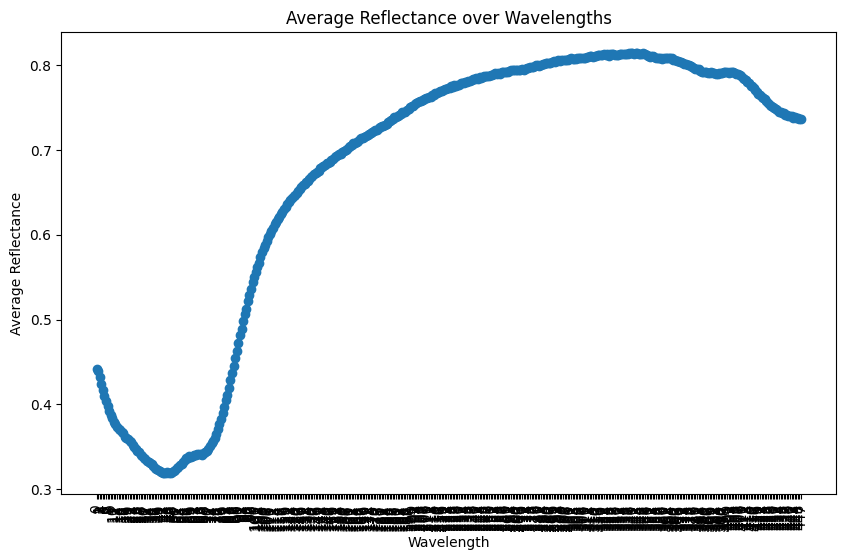

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1123236.8750 - mae: 667.0022 - val_loss: 1696976.2500 - val_mae: 773.9603
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1175848.2500 - mae: 675.0396 - val_loss: 1693476.2500 - val_mae: 772.6074
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1088040.5000 - mae: 627.8959 - val_loss: 1689589.8750 - val_mae: 771.2733
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1163742.3750 - mae: 668.1473 - val_loss: 1684869.0000 - val_mae: 769.6643
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1000881.7500 - mae: 620.1205 - val_loss: 1679234.2500 - val_mae: 768.0323
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1028194.1875 - mae: 644.0146 - val_loss: 1672362.3750 - val_mae: 766.1339
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1393117.1250 - mae: 745.9129 - val_loss: 1663870.0000 - val_mae: 763.7940
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1086385.1250 - mae

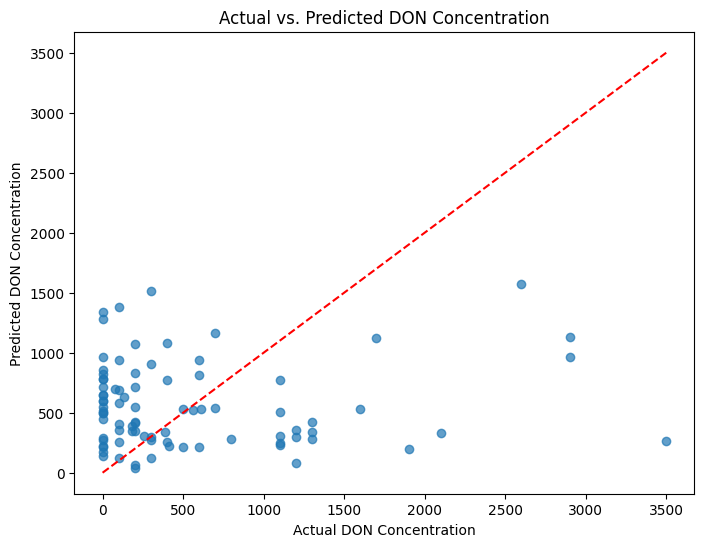

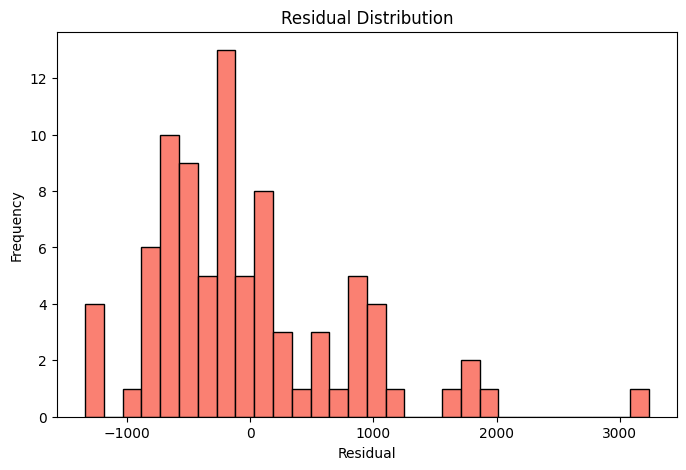

In [ ]:
# %% [markdown]
# ## 3. Data Preprocessing
#
# This section includes missing value imputation, outlier handling, feature standardization,
# and optional dimensionality reduction via PCA.

# %%
# Impute missing values only for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
logger.info("Missing values in numeric columns imputed using column means.")

# %%
# Define target column and remove outliers using the IQR method
target_col = "vomitoxin_ppb"
if target_col not in data.columns:
    logger.error("Target column not found in dataset!")
    raise ValueError("Target column not found in dataset!")

Q1 = data[target_col].quantile(0.25)
Q3 = data[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

initial_shape = data.shape
data = data[(data[target_col] >= lower_bound) & (data[target_col] <= upper_bound)]
logger.info(f"Outliers removed using IQR. Data shape changed from {initial_shape} to {data.shape}.")

# %%
# Drop the non-numeric 'hsi_id' column from the DataFrame, if present
if 'hsi_id' in data.columns:
    data.drop(columns=['hsi_id'], inplace=True)

# Separate features and target
features = data.drop(columns=[target_col])
target = data[target_col]

# Standardize features using only numeric columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
logger.info("Features standardized.")

# %%
# Apply PCA to reduce dimensionality while retaining 95% variance
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)
logger.info(f"PCA applied. Original features: {scaled_features.shape[1]}, Reduced features: {pca_features.shape[1]}")

# %%
# Visualize average reflectance across wavelengths (using original features)
avg_reflectance = features.mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_reflectance.index, avg_reflectance.values, marker='o')
plt.title("Average Reflectance over Wavelengths")
plt.xlabel("Wavelength")
plt.ylabel("Average Reflectance")
plt.xticks(rotation=90)
plt.show()





# %% [markdown]
# ## 4. Model Training
#
# Split the data into training and testing sets and build a simple neural network using Keras.

# %%
# Use the PCA-transformed features for modeling
X_train, X_test, y_train, y_test = train_test_split(pca_features, target.values, test_size=0.2, random_state=42)
logger.info(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# %%
# Define a function to build the neural network model
def build_model(input_dim: int) -> Sequential:
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build and summarize the model
model = build_model(X_train.shape[1])
model.summary()

# %%
# Train the model using early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# %% [markdown]
# ## 5. Model Evaluation
#
# Compute evaluation metrics and visualize model performance.

# %%
# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
logger.info(f"Evaluation Metrics - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# %%
# Scatter plot: Actual vs. Predicted DON Concentration
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

# %%
# Residual analysis: Histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='salmon', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()




# IQR did not result in good fitting, other outlier removal methods--


<ipython-input-4-96469763725b>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["log_target"] = np.log1p(data[target_col])  # log(1 + x) to handle zeros safely


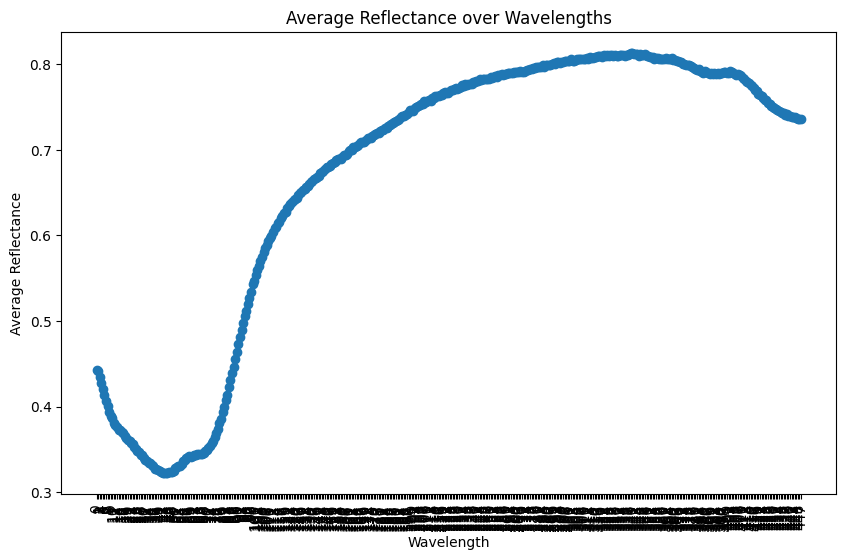

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 32.0862 - mae: 4.7046 - val_loss: 29.3045 - val_mae: 4.8595
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 22.7967 - mae: 4.0234 - val_loss: 21.8888 - val_mae: 4.2388
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 17.9585 - mae: 3.6551 - val_loss: 16.6137 - val_mae: 3.6211
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.5320 - mae: 3.6924 - val_loss: 14.6549 - val_mae: 3.3782
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.3592 - mae: 3.3998 - val_loss: 13.6473 - val_mae: 3.2710
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14.4400 - mae: 3.2475 - val_loss: 13.4567 - val_mae: 3.2587
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 12.7057 - mae: 3.0975 - val_loss: 13.4263 - val_mae: 3.2764
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13.6958 - mae: 3.1955 - val_loss: 13.7161 - val_mae: 3.3294
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss

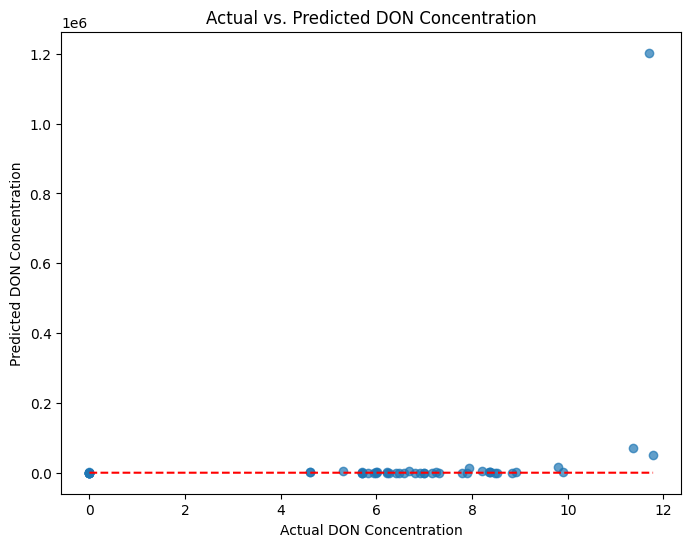

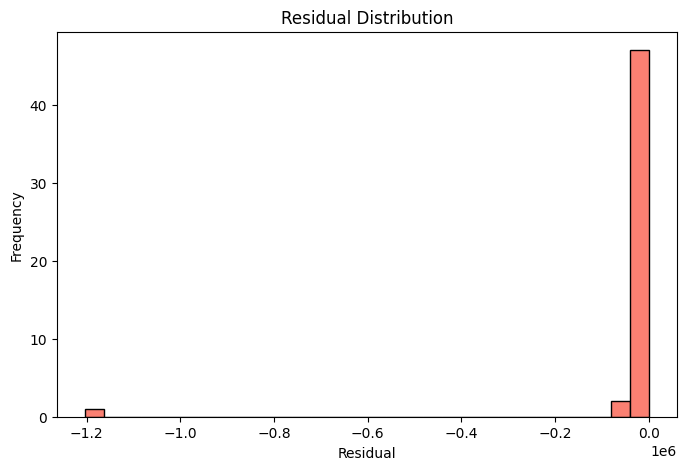

In [ ]:
# %% [markdown]
# ## 3. Data Preprocessing
#
# This section includes missing value imputation, log transformation of the target,
# feature standardization, and optional dimensionality reduction via PCA.

# %%
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Impute missing values only for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
logger.info("Missing values in numeric columns imputed using column means.")

# Define target column
target_col = "vomitoxin_ppb"
if target_col not in data.columns:
    logger.error("Target column not found in dataset!")
    raise ValueError("Target column not found in dataset!")

# Drop the non-numeric 'hsi_id' column from the DataFrame, if present
if 'hsi_id' in data.columns:
    data.drop(columns=['hsi_id'], inplace=True)

# -------------------
# Log Transform Step
# -------------------
# 1. Create a new column with log-transformed target
data["log_target"] = np.log1p(data[target_col])  # log(1 + x) to handle zeros safely

# 2. Separate features and the transformed target
features = data.drop(columns=[target_col, "log_target"])  # drop both original & new target columns from features
target = data["log_target"]

logger.info("Target transformed using log1p (log(1 + x)).")

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
logger.info("Features standardized.")

# Apply PCA to reduce dimensionality while retaining 95% variance
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)
logger.info(f"PCA applied. Original features: {scaled_features.shape[1]}, Reduced features: {pca_features.shape[1]}")

# Visualize average reflectance across wavelengths (using original features)
avg_reflectance = features.mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_reflectance.index, avg_reflectance.values, marker='o')
plt.title("Average Reflectance over Wavelengths")
plt.xlabel("Wavelength")
plt.ylabel("Average Reflectance")
plt.xticks(rotation=90)
plt.show()





# %% [markdown]
# ## 4. Model Training
#
# Split the data into training and testing sets and build a simple neural network using Keras.

# %%
# Use the PCA-transformed features for modeling
X_train, X_test, y_train, y_test = train_test_split(pca_features, target.values, test_size=0.2, random_state=42)
logger.info(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# %%
# Define a function to build the neural network model
def build_model(input_dim: int) -> Sequential:
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build and summarize the model
model = build_model(X_train.shape[1])
model.summary()

# %%
# Train the model using early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# %% [markdown]
# ## 5. Model Evaluation
#
# Compute evaluation metrics and visualize model performance.

# %%
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)          # invert log1p -> expm1
y_test_original = np.expm1(y_test)     # also invert the test labels

mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
logger.info(f"Evaluation Metrics - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# %%
# Scatter plot: Actual vs. Predicted DON Concentration
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

# %%
# Residual analysis: Histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='salmon', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()



,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,849 (120.50 KB)

 Trainable params: 30,849 (120.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 128164736.0000 - mae: 2730.6794 - val_loss: 203193264.0000 - val_mae: 4084.7598
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 166398192.0000 - mae: 3035.8247 - val_loss: 203138192.0000 - val_mae: 4078.7976
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 164480320.0000 - mae: 3185.7598 - val_loss: 203057904.0000 - val_mae: 4069.9089
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 212931712.0000 - mae: 3240.5608 - val_loss: 202957664.0000 - val_mae: 4058.3687
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 245419648.0000 - mae: 3732.8298 - val_loss: 202817488.0000 - val_mae: 4042.9155
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117159768.0000 - mae: 2579.8069 - val_loss: 202640976.0000 - val_mae: 4030.7129
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 152937680.0000 - mae: 2900.2288 - val_loss: 202405984.0000 - val_mae: 4016.1777
Epoch 8/100
10/10 ━━

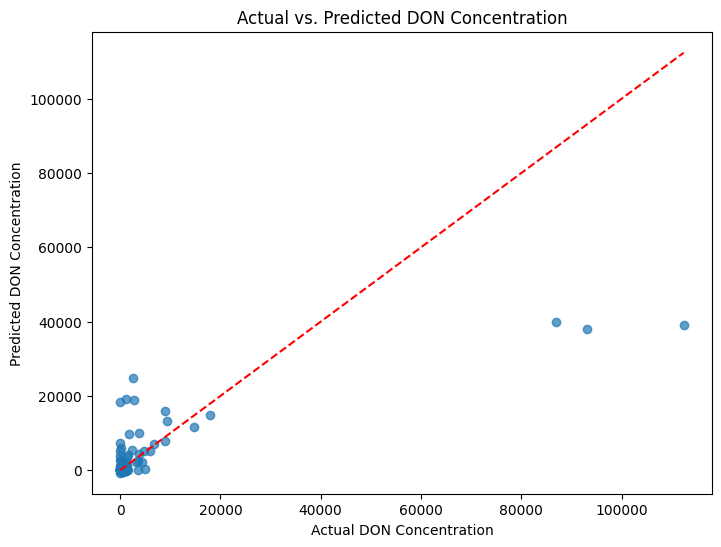

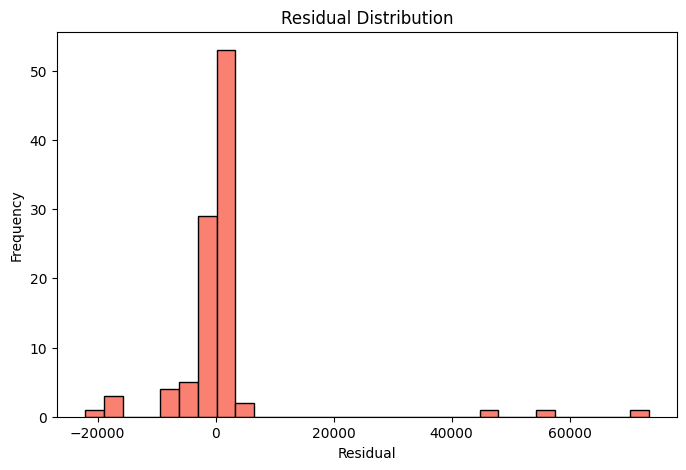

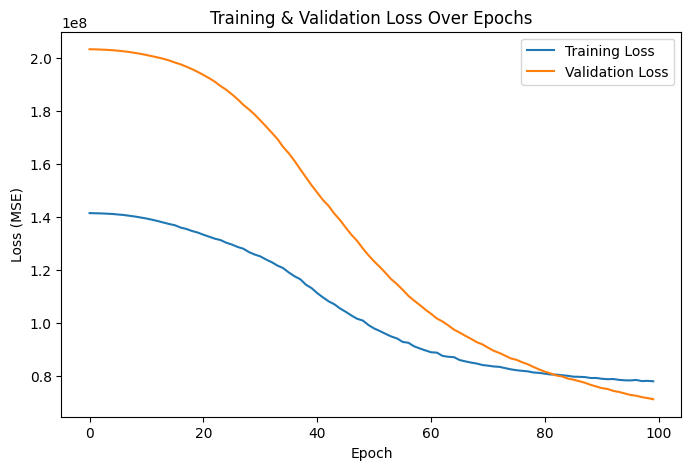

'\n## Conclusion\n\n- **No Outlier Removal**: We keep all rows intact (except for missing value imputation).\n- **No PCA**: We train directly on the scaled features.\n- **Neural Network**: Simple feedforward model.\n- **Evaluation**: Computed MAE, RMSE, R², plus scatter/residual plots.\n'

In [ ]:
# %% [markdown]
"""
# Simple End-to-End Pipeline (No PCA, No Outlier Removal)

**Pipeline**:
1. **Load & Inspect Dataset**
2. **Missing Value Imputation** (mean for numeric columns)
3. **Drop ID Column** (if any)
4. **Feature Scaling** (StandardScaler)
5. **Neural Network** for regression
6. **Model Evaluation** (MAE, RMSE, R²) + Visualizations

"""

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# %% [markdown]
# ## 1. Load & Inspect Dataset

# %%
data_path = "MLE-Assignment.csv"

try:
    data = pd.read_csv(data_path)
    logger.info("Dataset loaded successfully.")
except Exception as e:
    logger.error(f"Error loading dataset: {e}")
    raise

# Display a few rows to confirm structure
display(data.head())

# %% [markdown]
# ## 2. Missing Value Imputation

# %%
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
logger.info("Missing values in numeric columns imputed with column means.")

# %% [markdown]
# ## 3. Drop ID Column (If Present)

# %%
# If 'hsi_id'
if "hsi_id" in data.columns:
    data.drop(columns=["hsi_id"], inplace=True)
    logger.info("Dropped 'hsi_id' column.")

# %% [markdown]
# ## 4. Separate Features & Target, Scale Features

# %%
target_col = "vomitoxin_ppb"
if target_col not in data.columns:
    logger.error(f"Target column '{target_col}' not found in dataset!")
    raise ValueError(f"Target column '{target_col}' not found in dataset!")

features = data.drop(columns=[target_col])
target = data[target_col]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
logger.info("Features standardized.")

# %% [markdown]
# ## 5. Train-Test Split

# %%
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features,
    target.values,
    test_size=0.2,
    random_state=42
)
logger.info(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# %% [markdown]
# ## 6. Build & Train Neural Network

# %%
def build_model(input_dim: int) -> Sequential:
    """
    Build a simple feedforward neural network for regression.
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)  # Single output neuron for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

model = build_model(X_train.shape[1])
model.summary()

# %%
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# %% [markdown]
# ## 7. Model Evaluation

# %%
y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

logger.info(f"Evaluation Metrics - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# %% [markdown]
# **Scatter Plot: Actual vs. Predicted**

# %%
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

# %% [markdown]
# **Residual Analysis**

# %%
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='salmon', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# %% [markdown]
# **Training History (Optional)**

# %%
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# %% [markdown]
"""
## Conclusion

- **No Outlier Removal**: We keep all rows intact (except for missing value imputation).
- **No PCA**: We train directly on the scaled features.
- **Neural Network**: Simple feedforward model.
- **Evaluation**: Computed MAE, RMSE, R², plus scatter/residual plots.
"""
